# Analysis of Apple Watches

The [Apple website](https://www.apple.com/watch/compare/) shows all available Apple Watch models with their features. We scrape this information.

In [1]:
import httpx
from bs4 import BeautifulSoup

r = httpx.get("https://www.apple.com/watch/compare/")
html_doc = r.text
soup = BeautifulSoup(html_doc, "html.parser")
devices_html = soup.find_all("div", class_="device-content with-list-bullet")

We extract the features and store them with the watch models in `Watch` objects.

Later we want to match features between differen watch models. For this purpose we define a linear order on the watches: A watch is considered "smaller" if it has less features than the other watch. If they have both the same number of features, the watch the the alphabetical smaller name is considered smaller.

In [2]:
from collections import defaultdict
from pprint import pprint
from typing import List

from attrs import define
from pyrsistent import PVector
from pyrsistent import pvector


@define(frozen=True)
class Watch:
    name: str
    features: PVector

    def __lt__(self, other: "Watch") -> bool:
        if len(self.features) < len(other.features):
            return True
        if (len(self.features) == len(other.features)) and (self.name < other.name):
            return True
        return False


watches = []

for device in devices_html:
    watches.append(
        Watch(
            name=device.h3.text,
            features=pvector(li.text for li in device.find_all("li")),
        )
    )

watches.sort()
pprint([(_.name, len(_.features)) for _ in watches])

[('Apple\xa0Watch Series\xa01', 11),
 ('Apple\xa0Watch Series\xa02', 13),
 ('Apple\xa0Watch Series\xa03', 14),
 ('Apple\xa0Watch Series\xa04', 14),
 ('Apple\xa0Watch Series\xa05', 14),
 ('Apple\xa0Watch Series\xa06', 14),
 ('Apple\xa0Watch\xa0SE', 14),
 ('Apple\xa0Watch\xa0SE (1st\xa0generation)', 14),
 ('Apple\xa0Watch Series\xa07', 15),
 ('Apple\xa0Watch Series\xa08', 16),
 ('Apple\xa0Watch Series\xa09', 16),
 ('Apple\xa0Watch Ultra\xa02', 18),
 ('Apple\xa0Watch\xa0Ultra', 18)]


The features are written as free text. While the same feature uses the same text, it's harder to find what feature of a newer model matches to which feature of an older model.

Using an NLP model from [huggingface](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) we compute embeddings for the features of all watches.

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = defaultdict()

for watch in watches:
    # print(watch.name)
    embeddings[watch] = model.encode(watch.features, convert_to_tensor=True)

In [4]:
import itertools
from collections import Counter
from typing import Dict

import torch
from sentence_transformers import util


def dd():
    return defaultdict(dd)


def derive_mappings(matrix: torch.Tensor) -> Dict[int, int]:
    l1, l2 = matrix.size()
    maxs, indices = torch.max(matrix, dim=1)
    naive_map = {i: indices[i].item() for i in range(l1)}
    # pprint(naive_map)
    if max((vals := (c := Counter(naive_map.values())).values())) > 1:
        # print(c)
        _too_complicated = f"Too complicated: {c}"
        if len(dups := [_ for _ in c if c[_] > 1]) > 1:
            raise ValueError("More than one conflict. " + _too_complicated)
        target = dups[0]
        if c[target] > 2:
            raise ValueError(
                "More than two features point to same feature. " + _too_complicated
            )
        # print(f"{dups=}")
        features = [i for i in naive_map if naive_map[i] == dups[0]]
        i, j = features
        # print(i, j, maxs[i], maxs[j])
        if maxs[i] > maxs[j]:
            i, j = j, i
        # target_2 = (row:=matrix[i].values()).index(max(v for v in row if v < maxs[i]))
        # print(target_2)
        val_2, target_2 = (top2 := matrix[i].topk(2)).values[1].item(), top2.indices[
            1
        ].item()
        if (
            len(
                [val for i in range(l1) if (val := matrix[i][target_2].item()) >= val_2]
            )
            > 1
        ):
            raise ValueError(
                f"Second best mapping for feature {i_2} is also a good (or better) mapping for other features. "
                + _too_complicated
            )
        if target_2 in vals:
            raise ValueError(
                f"New target {target_2} for feature {i_2} has already been mapped. "
                + _too_complicated
            )
        naive_map[i] = target_2
    return naive_map


scores = defaultdict(dd)
mappings = defaultdict(dd)

for (w1, w2) in itertools.combinations(watches, 2):
    assert w1 < w2
    scores[(w1, w2)] = (matrix := util.cos_sim(embeddings[w1], embeddings[w2]))
    mappings[(w1, w2)] = derive_mappings(matrix)

80 243 18
0 {'International emergency calling,9 Emergency SOS,8 Crash Detection,8 and Fall Detection', 'International emergency calling,9 Emergency SOS,8 Crash Detection,8 and Fall Detection; Siren', 'Emergency SOS8', 'International emergency calling,9 Emergency SOS,8 and Fall Detection', 'Emergency SOS8 and Fall Detection'}


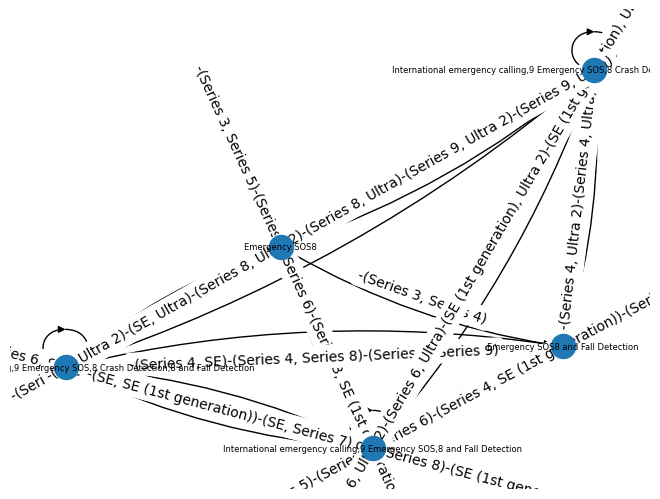

1 {'Dust resistant (IP6X)24', 'Dust resistant (IP6X)25', 'Dust resistant (IP6X)33', 'Dust resistant (IP6X)35'}


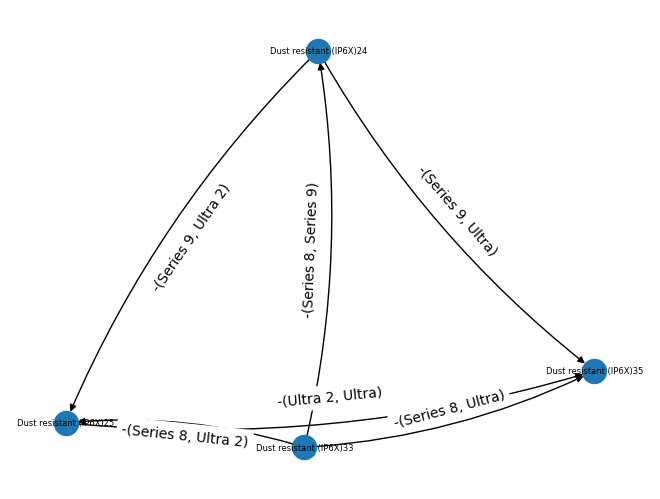

2 {'Temperature sensor,6 blood oxygen sensor;3 electrical heart sensor and third-generation optical heart sensor', 'Optical heart sensor', 'Temperature sensor;6 blood oxygen sensor;3 electrical heart sensor and third-generation optical heart sensor; depth gauge; water temperature sensor', 'Second-generation optical heart sensor', 'Electrical heart sensor and second-generation optical heart sensor', 'Blood oxygen sensor;3 electrical heart sensor and third-generation optical heart sensor'}


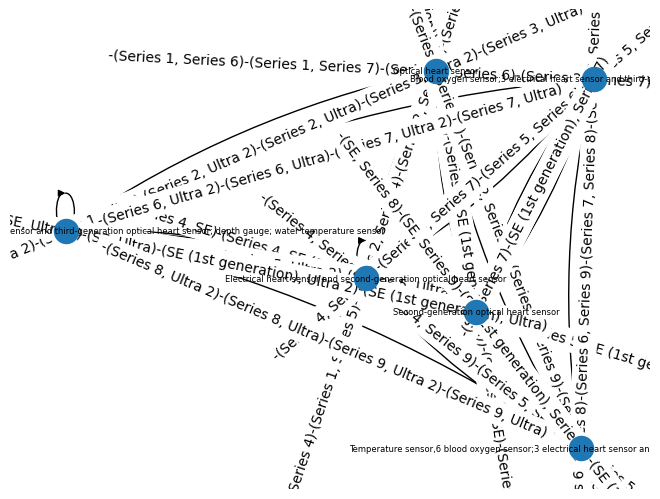

3 {'S7 SiP with 64-bit dual-core processor; W3 wireless chip; U1 chip (Ultra Wideband)26', 'S4 SiP with 64-bit dual-core processor; W3 wireless chip', 'S8 SiP with 64-bit dual-core processor; W3 wireless chip; U1 chip (Ultra Wideband)26', 'S3 SiP with dual-core processor; W2 wireless chip', 'S2 with dual-core processor', 'S5 SiP with 64-bit dual-core processor; W3 wireless chip', 'S1P with dual-core processor', 'S6 SiP with 64-bit dual-core processor; W3 wireless chip; U1 chip (Ultra Wideband)26', 'S9 SiP with 64-bit dual-core processor; W3 wireless chip; second-generation Ultra Wideband chip26', 'S8 SiP with 64-bit dual-core processor; W3 wireless chip'}


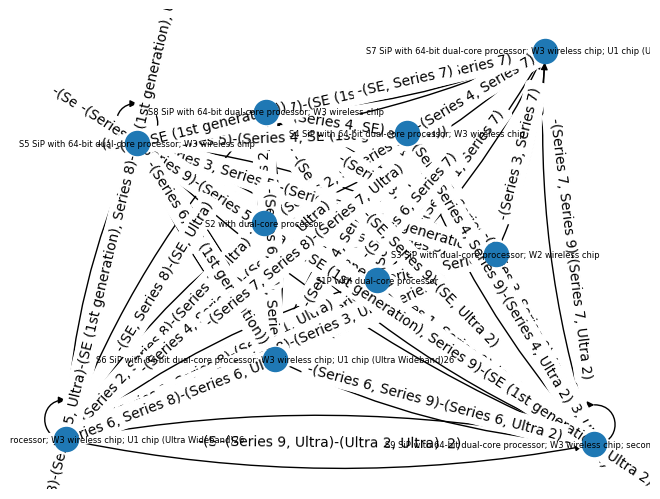

4 {'Retina LTPO OLED display, up to 1000 nits', 'Always-On Retina LTPO OLED display, up to 2000 nits', 'Second-generation Retina OLED display, up to 1000 nits', 'Second-generation Retina OLED display', 'Always-On Retina LTPO OLED display, up to 1000 nits', 'Always-On Retina LTPO OLED display, up to 3000 nits', 'Retina OLED display'}


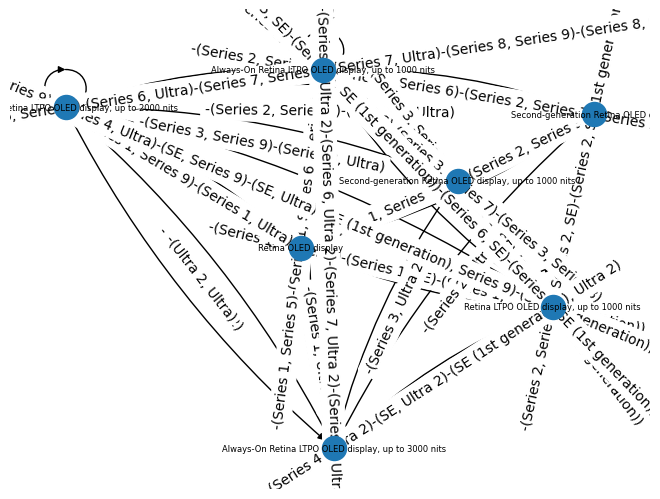

5 {'GPS + Cellular model', 'GPS and GPS + Cellular models', 'GPS model'}


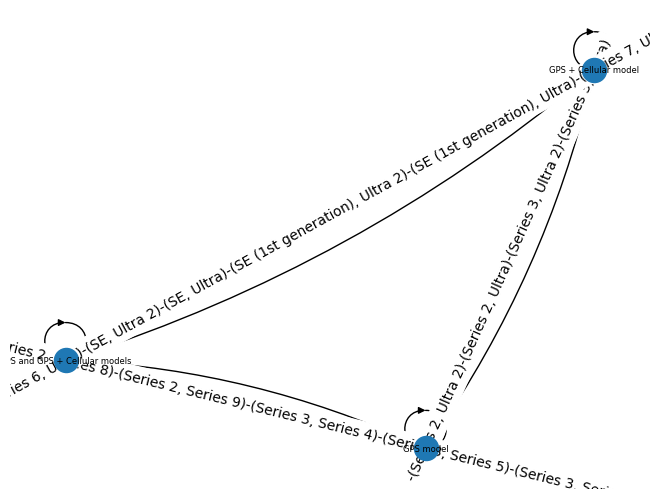

6 {'Dual speakers and three-mic array with beamforming', 'Built-in speaker and mic'}


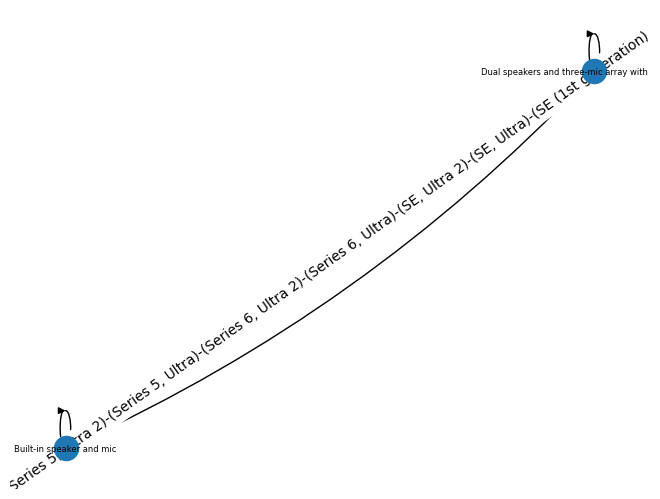

7 {'Ion-X glass display on aluminum cases; sapphire crystal display on stainless steel cases', 'Ion-X glass display on aluminum cases; sapphire crystal display on stainless steel, titanium, and ceramic cases', 'Ion-X glass display', 'Ion-X glass display on aluminum cases; sapphire crystal display on stainless steel and titanium cases', 'Ion-X glass display on aluminum cases; sapphire crystal display on stainless steel and ceramic cases', 'Flat sapphire crystal display'}


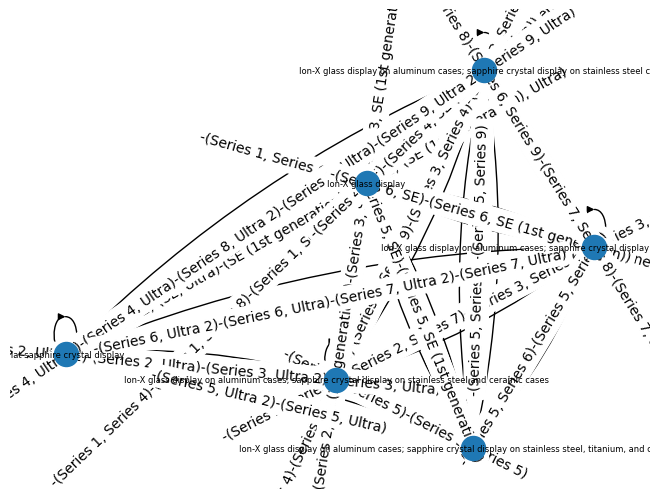

8 {'32GB capacity', '16GB capacity', '8GB capacity', '64GB capacity'}


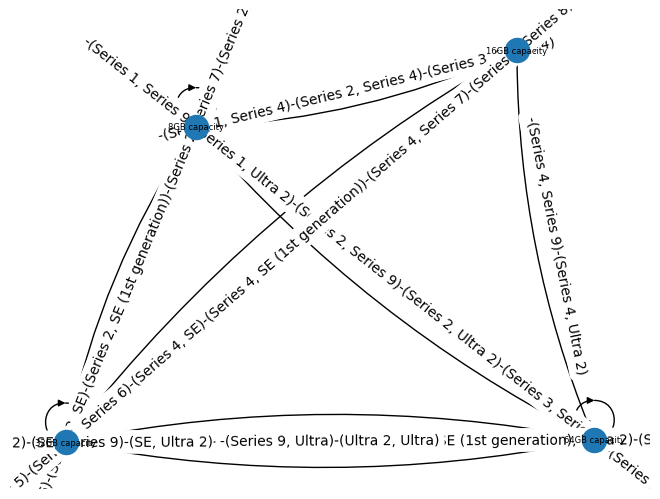

9 {'Digital Crown with haptic feedback', 'Digital Crown with haptic feedback; side button; Action button; double tap gesture; on-device Siri', 'Digital Crown with haptic feedback; side button; double tap gesture; on-device Siri', 'Digital Crown', 'Digital Crown with haptic feedback; side button; Action button; Siri', 'Digital Crown with haptic feedback; Siri'}


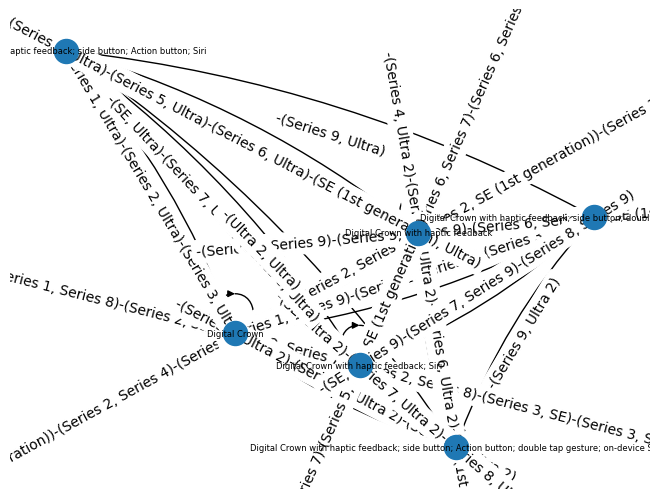

10 {'Wi-Fi and Bluetooth 4.2', 'LTE and UMTS,13 Wi-Fi, and Bluetooth 5.0', 'LTE and UMTS,13 Wi-Fi 4 (80211n), and Bluetooth 5.3', 'Wi-Fi and Bluetooth 4.0'}


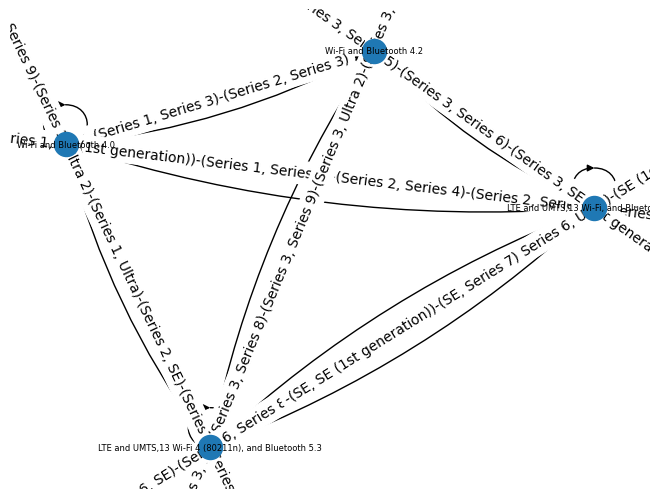

11 {'GPS/GNSS', 'GPS/GNSS and barometric altimeter', 'GPS/GNSS, compass, and barometric altimeter', 'GPS/GNSS, compass, and always-on altimeter'}


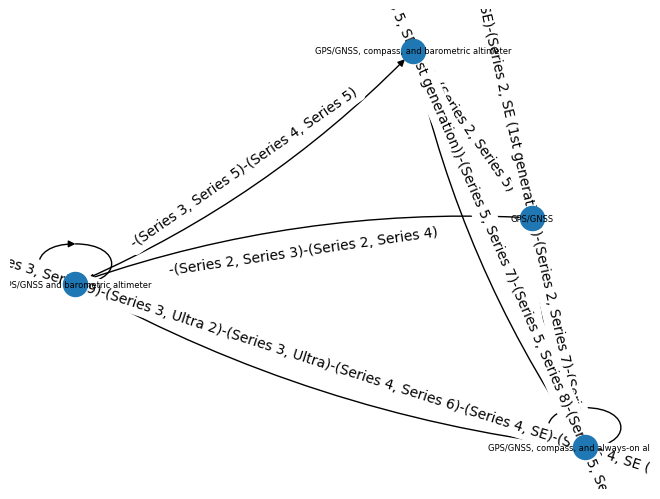

12 {'49mm case', '38mm or 42mm case', '40mm or 44mm case', '41mm or 45mm case'}


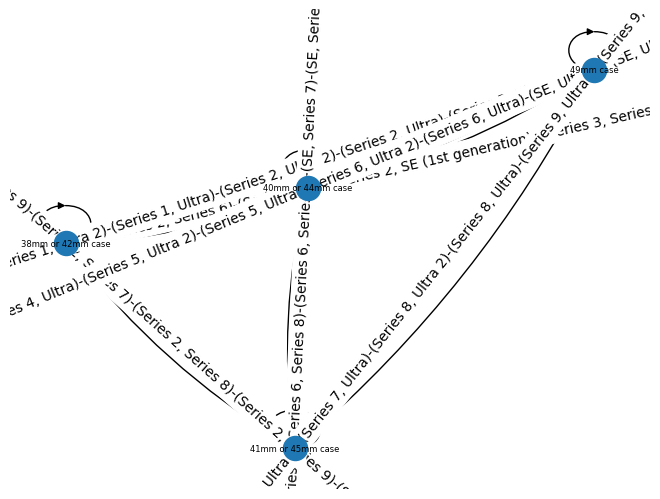

13 {'Water resistant 50 meters10', 'Splash resistant37', 'Water resistant 100 meters12', 'Water resistant 50 meters11'}


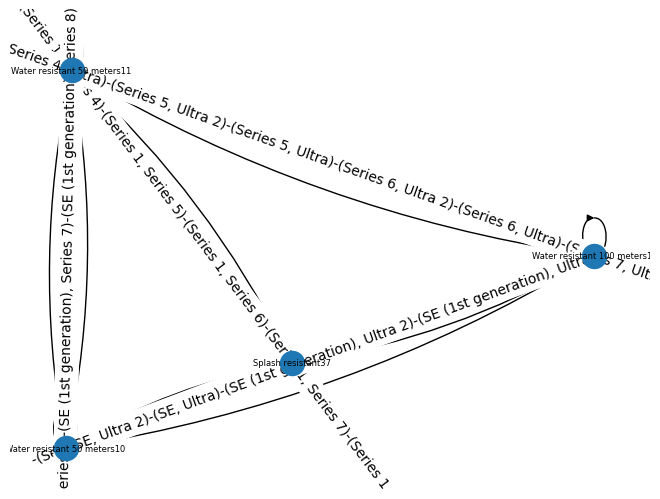

14 {'Fast charge time36', 'Fast charge time', 'Fast charge time18', 'Fast charge time34', 'Fast charge time19'}


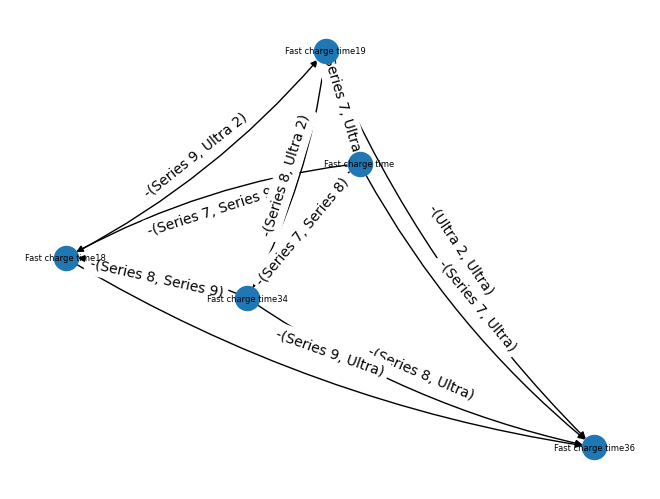

15 {'High and low heart rate notifications and irregular rhythm notification5; sleep stages', 'High and low heart rate notifications, irregular rhythm notification, and ECG app32; sleep stages', 'High and low heart rate notifications, irregular rhythm notification5; sleep stages', 'High and low heart rate notifications and irregular rhythm notification5'}


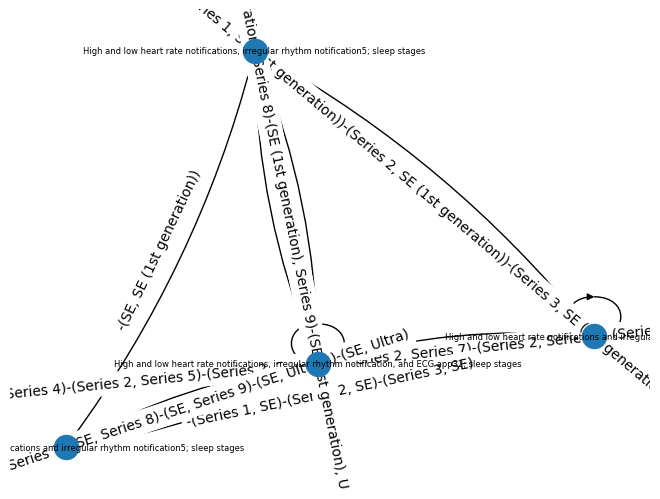

16 {'Recreational dive to 40 meters'}


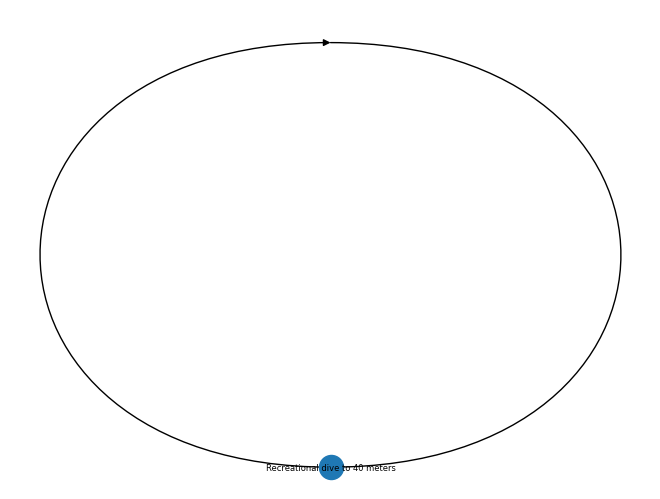

17 {'EN13319'}


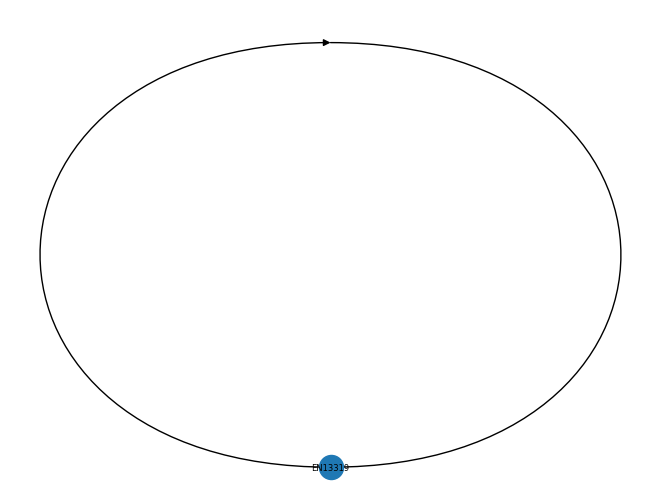

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

features = set()
for w in watches:
    features |= set(w.features)
# pprint(features)
G = nx.DiGraph()
G.add_nodes_from(features)
edge_labels = defaultdict(lambda: "")
for (w1, w2) in itertools.combinations(watches, 2):
    for (s, t) in mappings[(w1, w2)].items():
        # print(w1.name, w2.name, s, t)
        G.add_edge(*(e:=(w1.features[s], w2.features[t])))
        # print(e)
        # edge_labels[e]+=f"-({w1.name[12:]}, {w2.name[12:]})"
        if e[0] != e[1]:
            edge_labels[e]+=f"-({w1.name[12:]}, {w2.name[12:]})"
GC = list(nx.connected_components(G.to_undirected()))
print(G.number_of_nodes(), G.number_of_edges(), len(list(GC)))

# print("edges", nx.get_edge_attributes(G, "weight"))
# print(edge_labels)
for (i, component) in enumerate(GC):
    print(i, component)
    sG = G.subgraph(component)
    # print("type", type(sG))
    # print("edges", sG.edges)
    pos = nx.spring_layout(sG)
    # print(pos)
    plt.figure()
    nx.draw(sG, pos, with_labels=True, connectionstyle='arc3, rad = 0.1', font_size=6)
    nx.draw_networkx_edge_labels(sG, pos, edge_labels={e:l for (e,l) in edge_labels.items() if any(n in e for n in component)})
    # plt.axis_off()
    # fig.tight_layout()
    plt.show()
    if i >= 0:
        # break
        pass

In [6]:
@define(frozen=True)
class FeatureNode:
    watch: Watch
    index: int

    def name(self):
        return watch.features[self.index]


feature_nodes = [
    FeatureNode(watch, index)
    for watch in watches
    for index in range(len(watch.features))
]
print(len(feature_nodes))

191


## Transitivity

The same feature `i` of watch `w1` should be mapped to the same feature `j` of `w3` directly or via feature `k` of watch `w2` (if `i` is mapped to `k`).

In [7]:
for (w1, w2, w3) in itertools.combinations(watches, 3):
    assert w1 < w2 < w3
    m1, m2, m12 = mappings[w1,w2], mappings[w2,w3], mappings[w1,w3]
    # print(m1, m2, m12)
    for i in range(len(w1.features)):
        # print(m1[i])
        assert (l:=m2[m1[i]])==(r:=m12[i]), f"({w1.name}, {w2.name}, {w3.name}): {w1.features[i]} maps to {w3.features[l]} and {w3.features[r]}"



In [8]:
import pandas as pd

i = 0

for w in watches:
    for c in GC:
        assert len(c.intersection(w.features)) <= 1
        # print(c.intersection(w.features))
        i+=1
print(f"{i} tests successful")


def pop_or_none(s: set):
    if len(s) >= 1:
        return s.pop()
    return None

df = pd.DataFrame(
    data=[{w.name: pop_or_none(c.intersection(w.features)) for w in watches} for c in GC]
)

234 tests successful


In [134]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)
df

<IPython.core.display.Javascript object>

Apple Watch Series  1  \
0                                        8GB capacity   
1                                  Splash resistant31   
2                                                None   
3                                 Ion-X glass display   
4                        S1P with dual-core processor   
5   High and low heart rate notifications and irre...   
6                             Wi-Fi and Bluetooth 4.0   
7                                Optical heart sensor   
8                                                None   
9                            Built-in speaker and mic   
10                                               None   
11                                Retina OLED display   
12                                               None   
13                                      Digital Crown   
14                                               None   
15                                  38mm or 42mm case   

                                 Apple Watch Series 2  \
0                                        8GB capacity   
1                          Water resistant 50 meters8   
2                                           GPS model   
3   Ion-X glass display on aluminum cases; sapphir...   
4                         S2 with dual-core processor   
5   High and low heart rate notifications and irre...   
6                             Wi-Fi and Bluetooth 4.0   
7                                Optical heart sensor   
8                                                None   
9                            Built-in speaker and mic   
10                                               None   
11              Second-generation Retina OLED display   
12                                           GPS/GNSS   
13                                      Digital Crown   
14                                               None   
15                                  38mm or 42mm case   

                                       Apple Watch SE  \
0                                       32GB capacity   
1                          Water resistant 50 meters9   
2                       GPS and GPS + Cellular models   
3                                 Ion-X glass display   
4   S8 SiP with 64-bit dual-core processor; W3 wir...   
5   High and low heart rate notifications and irre...   
6            LTE and UMTS,17 Wi-Fi, and Bluetooth 5.3   
7              Second-generation optical heart sensor   
8   International emergency calling,16 Emergency S...   
9                            Built-in speaker and mic   
10                                               None   
11          Retina LTPO OLED display, up to 1000 nits   
12         GPS/GNSS, compass, and always-on altimeter   
13                 Digital Crown with haptic feedback   
14                                               None   
15                                  40mm or 44mm case   

                                 Apple Watch Series 3  \
0                                        8GB capacity   
1                          Water resistant 50 meters8   
2                                           GPS model   
3   Ion-X glass display on aluminum cases; sapphir...   
4   S3 SiP with dual-core processor; W2 wireless chip   
5   High and low heart rate notifications and irre...   
6                             Wi-Fi and Bluetooth 4.2   
7                                Optical heart sensor   
8                                      Emergency SOS2   
9                            Built-in speaker and mic   
10                                               None   
11  Second-generation Retina OLED display, up to 1...   
12                  GPS/GNSS and barometric altimeter   
13                                      Digital Crown   
14                                               None   
15                                  38mm or 42mm case   

                                 Apple Watch Series 4  \
0                                       16GB capacity   
1                          Water resis